## Setup

In [1]:
# set working directory
setwd("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/kp")

In [2]:
# load libraries
library(SummarizedExperiment)
library(DESeq2)
library(pheatmap)
library(ggplot2)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [3]:
# create function to normalize counts in deseq object

# assume rowRanges is a non-empty GRangesList and size factors were already computed (ex: using estimateSizeFactors())
normCounts <- function(se) {
  gene_length <- sum(width(rowRanges(se)))
  counts_norm <- apply(counts(se, normalized = TRUE), 2, 
                       function(x) {
                         1e3 * x / gene_length
                       })
  assays(se)$counts_norm <- counts_norm
  return(se)
}


In [4]:
# get functions from other files

# function to create a deseq dataset
source("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/functions_and_snippets/create_deseq_dataset.R")

# function to get de genes
source("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/functions_and_snippets/get_de_genes.R")


Attaching package: ‘glue’


The following object is masked from ‘package:SummarizedExperiment’:

    trim


The following object is masked from ‘package:GenomicRanges’:

    trim


The following object is masked from ‘package:IRanges’:

    trim




## Read data

In [5]:
# read in data

# define the root directory
root = "/Genomics/pritykinlab/share/eileen-rnaseq/processed"

# read in gene expression data
gene_counts <- readRDS(glue('{root}/KP-rna-counts.raw.rds'))

# read in gencode
gencode <- readRDS(glue('{root}/mm10_gencode.rds'))

# read in metadata
metadata <- read.csv(glue('{root}/kp_metadata.csv'), check.names = FALSE)


## Preprocess data

In [6]:
# prepare collection of all protein-coding exons for genes in gencode
exons <- gencode[(gencode$gene_type == 'protein_coding') & (gencode$type == 'exon')]
genes <- levels(as.factor(exons$gene_name))
exons_genes <- disjoin(split(exons, factor(exons$gene_name, levels = genes)))


In [7]:
# save the gene counts counts data in a dataframe
gene_counts_df <- as.data.frame(gene_counts$counts)

# fix the column headers of the gene counts data
names(gene_counts_df) <- gsub(".bam", "", names(gene_counts_df))

# put gene counts into a matrix
gene_counts_mat <- as.matrix(gene_counts_df)

# sort the gene names
#gene_names <- sort(rownames(gene_counts_mat))
gene_names <- sort(names(exons_genes))

# order gene_counts_mat according to sorted rownames
gene_counts_mat <- gene_counts_mat[gene_names, ]

# sort exons_genes
exons_genes <- exons_genes[gene_names]


In [8]:
# set the rownames of the metadata to be the sample names
rownames(metadata) <- metadata$SampleName

# change columns from characters to factors
metadata$Group <- as.factor(metadata$Group)
metadata$Gender <- as.factor(metadata$Gender)

# view the beginning of the metadata
head(metadata)


,SampleName,Genotype,Group,Gender,BodyWeightLoss,Tissue
,<chr>,<chr>,<fct>,<fct>,<dbl>,<chr>
8213-P-M-Liver,8213-P-M-Liver,Tp53 flox/flox,Control,M,NA,Liver
8233-P-M-Liver,8233-P-M-Liver,Tp53 flox/flox,Control,M,NA,Liver
8234-P-M-Liver,8234-P-M-Liver,Tp53 flox/flox,Control,M,NA,Liver
8211-KP-M-Liver,8211-KP-M-Liver,Kras; Tp53 flox/flox,Treatment,M,-15.80756,Liver
8212-KP-M-Liver,8212-KP-M-Liver,Kras; Tp53 flox/flox,Treatment,M,-10.78067,Liver
8231-KP-M-Liver,8231-KP-M-Liver,Kras; Tp53 flox/flox,Treatment,M,-10.46931,Liver


In [9]:
# filter and sort the gene_counts_mat to be in the same order as the metadata
# IMPORTANT: the order of the columns of gene_counts_mat needs to be the same as the order of the rows of the metadata!
gene_counts_mat <- gene_counts_mat[, metadata$SampleName]



In [10]:
# confirm that rows of metadata match columns of gene_counts_mat
all(rownames(metadata) == colnames(gene_counts_mat))


[1] TRUE

## Liver data

In [11]:
# set condition where tissue is liver
liver_cond <- metadata$Tissue == "Liver"

# get subset of gene_counts_mat where tissue is liver
gene_counts_mat_liver <- gene_counts_mat[, metadata[liver_cond, ]$SampleName]

# get subset of metadata where tissue is liver
metadata_liver <- metadata[liver_cond, ]


In [12]:
# confirm that rows of metadata for liver match columns of gene_counts_mat for liver
all(rownames(metadata_liver) == colnames(gene_counts_mat_liver))


[1] TRUE

In [13]:
# create summarized experiment object for liver
gene_counts_se_liver <- SummarizedExperiment(list(counts = gene_counts_mat_liver), rowRanges = exons_genes)

# combine summarized experiment object with metadata
colData(gene_counts_se_liver) <- cbind(colData(gene_counts_se_liver), metadata_liver)

# remove genes on sex chromosome
gene_counts_se_liver_no_sex <- gene_counts_se_liver[all(!seqnames(gene_counts_se_liver) %in% c("chrX", "chrY"))]


In [14]:
# deseq (no adjustors)

# use create_deseq_dataset() to create deseq object from summarized experiment object
dds_liver_no_adj <- create_deseq_dataset(gene_counts_se_liver_no_sex, "Group")

# get top 5000 genes
normalized_counts_liver <- dds_liver_no_adj$normalized_counts[order(-rowMeans(dds_liver_no_adj$normalized_counts)), ][1:5000, ]


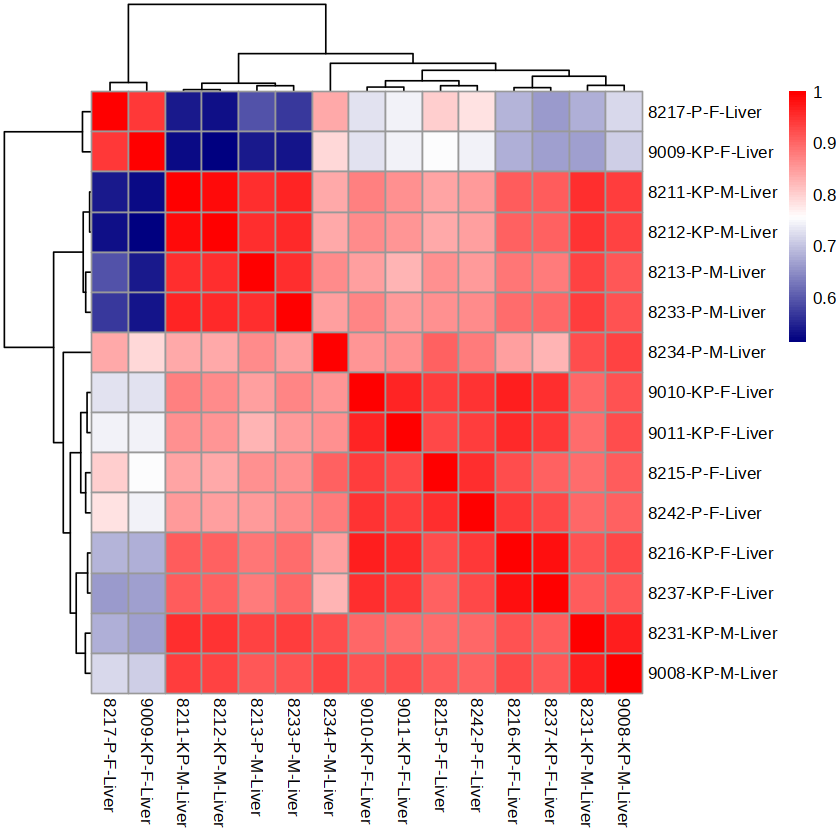

In [15]:
# heatmap samples

# get normalized counts correlation
normalized_counts_cor_liver <- cor(normalized_counts_liver, method = "spearman")

# create heatmap
pheatmap(normalized_counts_cor_liver, color = colorRampPalette(c("navy", "white", "red"))(100))


## DESeq

In [16]:
# deseq (no adjustors)

# use get_de_genes() to get de genes (deseq object created above)
res_liver_no_adj <- get_de_genes(dds_liver_no_adj$dds, "Group", "Treatment", "Control")

# sort results
res_liver_no_adj_ordered <- res_liver_no_adj$res[order(res_liver_no_adj$res$padj),]

# view the results
View(as.data.frame(res_liver_no_adj_ordered))

# save results to csv file
write.csv(as.data.frame(res_liver_no_adj_ordered), file = "res_liver_no_adj_ordered.csv")


using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 133 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aldh1a3,31.22912,2.7156556,0.27478599,9.882802,4.943095e-23,6.642531e-19
Tubb2a,812.07477,-2.0588644,0.21072081,-9.770580,1.505882e-22,1.011802e-18
Isyna1,268.98664,1.7590313,0.20589665,8.543273,1.304728e-17,4.383235e-14
Tmem176b,4505.89311,0.8183869,0.09549021,8.570375,1.031486e-17,4.383235e-14
Tmem176a,3609.70089,0.8111458,0.09784581,8.290042,1.132087e-16,3.042596e-13
Lcn2,1524.44870,3.4092831,0.42079418,8.102020,5.405384e-16,1.210626e-12
Syne4,57.31612,2.3831875,0.30691019,7.765097,8.158252e-15,1.566151e-11
Prtn3,524.20480,3.5452951,0.46592916,7.609086,2.760408e-14,4.636795e-11
Marco,360.47309,1.9060041,0.25738274,7.405330,1.308249e-13,1.953362e-10


In [17]:
# deseq (adjusted for gender)

# use create_deseq_dataset() to create deseq object from summarized experiment object
dds_liver_adj_gender <- create_deseq_dataset(gene_counts_se_liver_no_sex, "Group", "Gender")

# use get_de_genes() to get de genes
res_liver_adj_gender <- get_de_genes(dds_liver_adj_gender$dds, "Group", "Treatment", "Control")

# sort results
res_liver_adj_gender_ordered <- res_liver_adj_gender$res[order(res_liver_adj_gender$res$padj),]

# view the results
View(as.data.frame(res_liver_adj_gender_ordered))

# save results to csv file
write.csv(as.data.frame(res_liver_adj_gender_ordered), file = "res_liver_adj_gender_ordered.csv")


using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tubb2a,812.07477,-2.0638999,0.20569790,-10.033646,1.084367e-23,1.482438e-19
Aldh1a3,31.22912,2.7106603,0.27716861,9.779824,1.374492e-22,9.395337e-19
Isyna1,268.98664,1.8023614,0.19970464,9.025135,1.794734e-19,8.178603e-16
Fgl1,22725.46262,1.6346037,0.19108838,8.554176,1.187137e-17,4.057336e-14
Tmem176b,4505.89311,0.8177714,0.09778691,8.362790,6.125215e-17,1.674756e-13
Tmem176a,3609.70089,0.8086826,0.09971531,8.109914,5.065580e-16,1.154192e-12
Lcn2,1524.44870,3.1635902,0.39843654,7.940010,2.021648e-15,3.948278e-12
Syne4,57.31612,2.3484018,0.30133518,7.793321,6.527045e-15,1.115390e-11
Aqp8,1537.46802,-1.6825914,0.22402514,-7.510726,5.880056e-14,8.931805e-11


## PCA

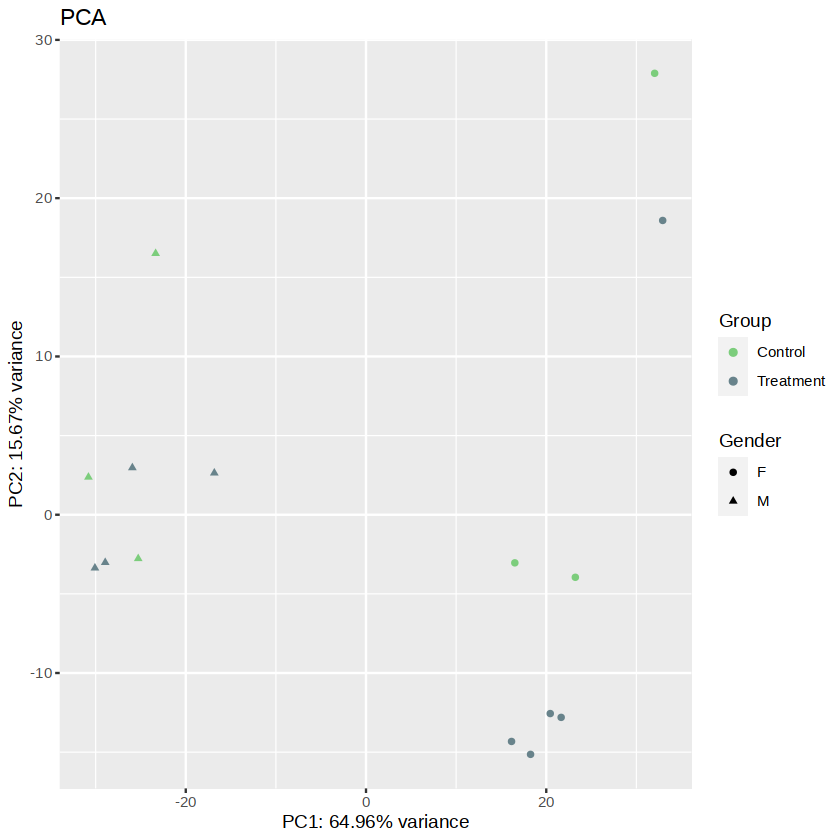

In [18]:
# pca plot (no adjustors)

# transform data to use in plot
vsd <- varianceStabilizingTransformation(dds_liver_no_adj$dds, blind = FALSE)

# create PCA plot
pcaData <- plotPCA(vsd, intgroup = c("Group", "Gender"), returnData = TRUE)

# get the percent variance from PCA plot
percentVar <- round(100 * attr(pcaData, "percentVar"), digits = 2)

# format plot
ggplot(pcaData, aes(x = PC1, y = PC2, color = Group, shape = Gender)) + 
    geom_point() +
    labs(x = paste0("PC1: ", percentVar[1], "% variance"),
         y = paste0("PC2: ", percentVar[2], "% variance"),
         color = "Group",
         shape = "Gender") +
    scale_color_manual(values = c("palegreen3", "lightblue4")) +
    ggtitle("PCA")


## Heatmap genes

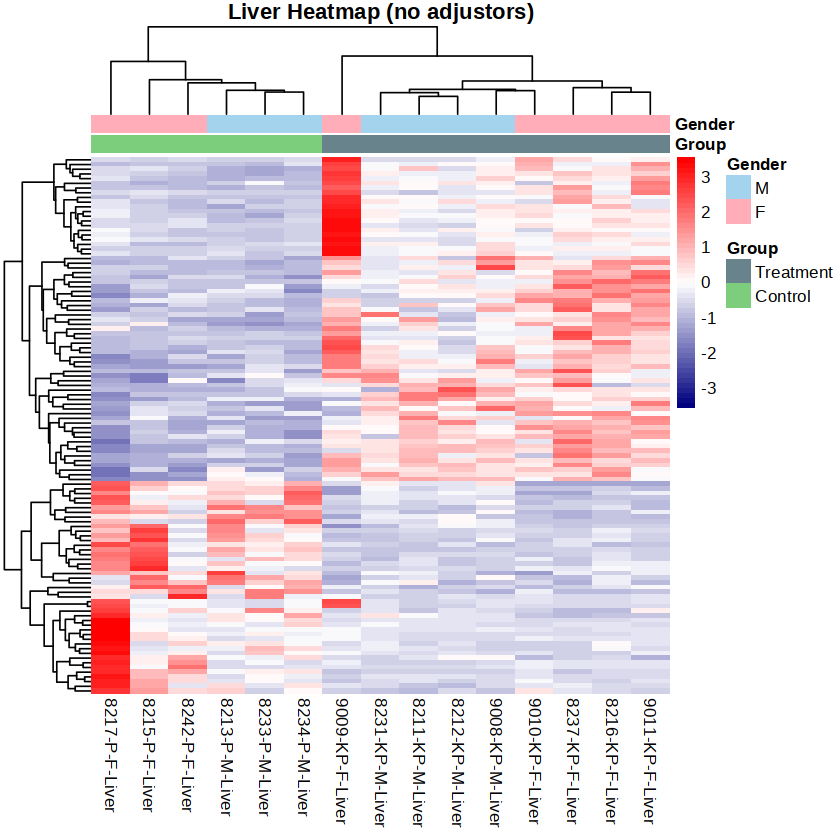

In [19]:
# heatmap genes (no adjustors)

# get subset of results where padj < 0.05
res_liver_hm_no_adj <- subset(res_liver_no_adj_ordered, padj < 0.05)

# sort results into descending LFC
res_liver_hm_no_adj <- res_liver_hm_no_adj[abs(res_liver_hm_no_adj$log2FoldChange) > 1, ]

# convert results to a dataframe
res_liver_hm_no_adj_df <- as.data.frame(res_liver_hm_no_adj)

# get counts that correspond to significant genes
mat_liver_hm_no_adj <- counts(dds_liver_no_adj$dds, normalized = TRUE)[rownames(res_liver_hm_no_adj_df), ]

# create dataframe for annotations
samples_list_liver_no_adj <- colnames(mat_liver_hm_no_adj)
samples_list_liver_no_adj_df <- metadata_liver[metadata_liver$SampleName %in% samples_list_liver_no_adj,]
samples_list_liver_no_adj_df_tmp <- data.frame(samples_list_liver_no_adj_df[, c("Group", "Gender")])
rownames(samples_list_liver_no_adj_df_tmp) <- samples_list_liver_no_adj_df$SampleName
samples_list_liver_no_adj_df <- samples_list_liver_no_adj_df_tmp
colnames(samples_list_liver_no_adj_df) <- c("Group", "Gender")

# create list of annotation colors
ann_colors_liver_no_adj <- list(Group = c(Treatment = "lightblue4", Control = "palegreen3"),
    Gender = c(M = "lightskyblue2", F = "lightpink1"))

# heatmap
pheatmap(mat_liver_hm_no_adj, scale = "row", color = colorRampPalette(c("navy", "white", "red"))(50), 
         annotation_col = samples_list_liver_no_adj_df, annotation_colors = ann_colors_liver_no_adj, 
         show_rownames = FALSE, main = "Liver Heatmap (no adjustors)")


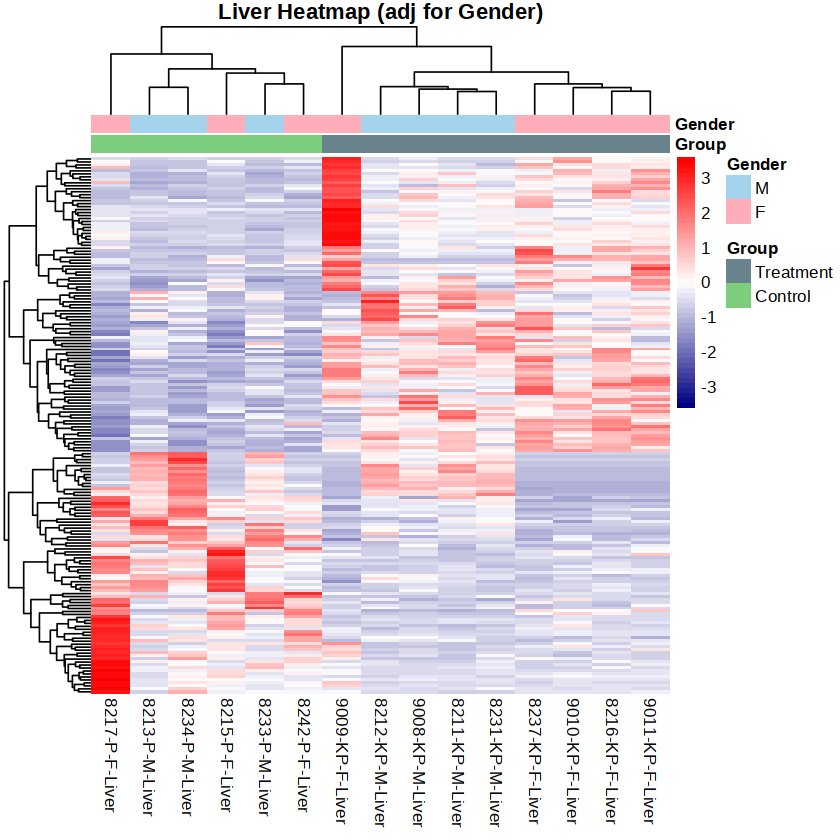

In [20]:
# heatmap genes (adj for gender)

# get subset of results where padj < 0.05
res_liver_hm_adj_gender <- subset(res_liver_adj_gender_ordered, padj < 0.05)

# sort results into descending LFC
res_liver_hm_adj_gender <- res_liver_hm_adj_gender[abs(res_liver_hm_adj_gender$log2FoldChange) > 1, ]

# convert results to a dataframe
res_liver_hm_adj_gender_df <- as.data.frame(res_liver_hm_adj_gender)

# get counts that correspond to significant genes
mat_liver_hm_adj_gender <- counts(dds_liver_adj_gender$dds, normalized = TRUE)[rownames(res_liver_hm_adj_gender_df), ]

# create dataframe for annotations
samples_list_liver_adj_gender <- colnames(mat_liver_hm_adj_gender)
samples_list_liver_adj_gender_df <- metadata_liver[metadata_liver$SampleName %in% samples_list_liver_adj_gender,]
samples_list_liver_adj_gender_df_tmp <- data.frame(samples_list_liver_adj_gender_df[, c("Group", "Gender")])
rownames(samples_list_liver_adj_gender_df_tmp) <- samples_list_liver_adj_gender_df$SampleName
samples_list_liver_adj_gender_df <- samples_list_liver_adj_gender_df_tmp
colnames(samples_list_liver_adj_gender_df) <- c("Group", "Gender")

# create list of annotation colors
ann_colors_liver_adj_gender <- list(Group = c(Treatment = "lightblue4", Control = "palegreen3"),
    Gender = c(M = "lightskyblue2", F = "lightpink1"))

# heatmap
pheatmap(mat_liver_hm_adj_gender, scale = "row", color = colorRampPalette(c("navy", "white", "red"))(50), 
         annotation_col = samples_list_liver_adj_gender_df, annotation_colors = ann_colors_liver_adj_gender, 
         show_rownames = FALSE, main = "Liver Heatmap (adj for Gender)")
